# Import Library and Load Model

In [1]:
from discode import models, utils
model_path = "weights/weights.pt" # please specify the model weight path
model = models.load(model_path) # if gpu available, it will automatically load on gpu
model.eval() # Model must be specified "eval"

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=480, out_features=480, bias=True)
        )
        (linear1): Linear(in_features=480, out_features=480, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=480, out_features=480, bias=True)
        (norm1): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=480, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=2, bias=True)
)

# Make Accession and Sequence as Variable

In [2]:
# Q9K3J3 is Streptomyces coelicolor malate dehydrogenase
name, sequence = "Q9K3J3", "MTRTPVNVTVTGAAGQIGYALLFRIASGQLLGADVPVKLRLLEITPALKAAEGTAMELDDCAFPLLQGIEITDDPNVAFDGANVALLVGARPRTKGMERGDLLEANGGIFKPQGKAINDHAADDIKVLVVGNPANTNALIAQAAAPDVPAERFTAMTRLDHNRALTQLAKKTGSTVADIKRLTIWGNHSATQYPDIFHATVAGKNAAETVNDEKWLADEFIPTVAKRGAAIIEARGASSAASAANAAIDHVYTWVNGTAEGDWTSMGIPSDGSYGVPEGIISSFPVTTKDGSYEIVQGLDINEFSRARIDASVKELSEEREAVRGLGLI"

# Predict the label of wildtype sequence

In [3]:
# The sequence data will be preprocessed with ESM2-t12 model
data = utils.tokenize_and_dataloader(name, sequence)

# The processed data will be transferred into model, and predict the probability, attention weights, and outlier residues
# The default threshold for selecting outliers is set to Z=2
outlier_idx, probability, predicted_label, _name, attention_weights = utils.model_prediction(data, model, threshold="Z=2")

In [4]:
# The first column of probability is NAD probability, and the second column is NADP probability
print(f"The label probability of NAD is {probability.detach().numpy()[0]:.3f}, NADP is {probability.detach().numpy()[1]:.3f}")

The label probability of NAD is 0.999, NADP is 0.001


# Plot the attention sum and outlier residues

The maximum attention sum is ... 1637.513
The threshold was ... Z=2
The outlier residues are ... ['A14', 'E43', 'I44', 'T45', 'G89']
The attention sum of A14 is ... 1251.160
The attention sum of E43 is ... 624.572
The attention sum of I44 is ... 1637.513
The attention sum of T45 is ... 430.036
The attention sum of G89 is ... 397.782


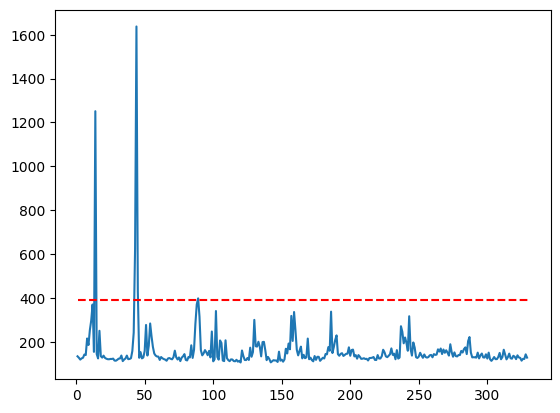

In [5]:
# The default threshold for selecting outliers is set to Z=2
utils.plot_attention_sum(attention_weights, sequence, threshold="Z=2")

# Changes in outlier residues based on supporting different thresholds

In [6]:
# The supported thresholds are as follows, with the default set to Z=2.
threshold_list = ["Z=1", "Z=2", "Z=3", "IQR", "0.90", "0.95", "0.99"]
for threshold in threshold_list:
    outlier_idx, _, _, _, _ = utils.model_prediction(data, model, threshold=threshold)
    print(f"{threshold} : {len(outlier_idx)} outliers, {outlier_idx}")

Z=1 : 18 outliers, [ 10  11  13  42  43  44  50  53  86  87  88  89 101 129 156 158 185 242]
Z=2 : 5 outliers, [13 42 43 44 88]
Z=3 : 3 outliers, [13 42 43]
IQR : 31 outliers, [  7   9  10  11  13  16  41  42  43  44  50  53  54  86  87  88  89  98
 101 129 156 158 159 168 185 189 236 237 239 242 286]
0.90 : 33 outliers, [  7   9  10  11  13  16  41  42  43  44  50  53  54  86  87  88  89  98
 101 108 129 156 158 159 168 185 188 189 236 237 239 242 286]
0.95 : 17 outliers, [ 10  11  13  42  43  44  53  86  87  88  89 101 129 156 158 185 242]
0.99 : 4 outliers, [13 42 43 44]


# Shortest-mode based mutation design

In [7]:
# The shortest method facilitates efficient exploration of designs for numerous outliers.
short = utils.scan_switch_mutation(model = model,
                                   max_num_mutation = 5,
                                   name = name,
                                   sequence = sequence,
                                   mode = "shortest",
                                   threshold = "IQR")
short

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation was derived in 2 mutations. Iteration stopped.


,NAD,NADP
Q9K3J3;E43S;I44R,0.292944,0.693356


# Iter_num-mode based mutation design

In [8]:
# When using the "iter" mode, strict thresholds like Z=3 and 0.99 are recommended for selecting a smaller number of outliers to manage design complexity
# When a switching design is obtained, scan only the combinations with the same number of mutations
iter_num = utils.scan_switch_mutation(model = model,
                                      max_num_mutation = 3,
                                      name = name,
                                      sequence = sequence,
                                      mode = "iter_num",
                                      threshold = "0.99")
iter_num

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation step (('Q9K3J3',), 1) end...
The mutation step (('Q9K3J3',), 2) end...
The mutation was found in 2step


,NAD,NADP
Q9K3J3;E43S;I44R,0.292944,0.693356
Q9K3J3;E43A;I44S,0.369982,0.621812
Q9K3J3;E43V;I44S,0.466299,0.516228


# Iter_prob-mode based mutation design

In [9]:
# Scan all combinations of mutations
iter_prob = utils.scan_switch_mutation(model = model,
                                       max_num_mutation = 3,
                                       name = name,
                                       sequence = sequence,
                                       mode = "iter_prob",
                                       threshold = "Z=3")
iter_prob

The wildtype label probability is ...tensor([9.9906e-01, 9.3004e-04])
The mutation step (('Q9K3J3',), 1) end...
The mutation step (('Q9K3J3',), 2) end...
The mutation step (('Q9K3J3',), 3) end...


,NAD,NADP
Q9K3J3;A14W;E43S;I44R,0.032487,0.966856
Q9K3J3;A14S;E43S;I44R,0.032630,0.966500
Q9K3J3;A14F;E43S;I44R,0.034164,0.965119
Q9K3J3;A14T;E43S;I44R,0.034285,0.965097
Q9K3J3;A14N;E43S;I44R,0.041305,0.957810
Q9K3J3;A14H;E43S;I44R,0.041699,0.957208
Q9K3J3;A14N;E43A;I44S,0.044097,0.956914
Q9K3J3;A14R;E43S;I44R,0.042032,0.956760
Q9K3J3;A14Y;E43S;I44R,0.043562,0.955386
Q9K3J3;A14T;E43A;I44S,0.048488,0.952378
